## 2 - Simple regression model in TensorFlow Probability




In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.python import tf2

import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

We've seen how to solve regression problems in TensorFlow 2.0 -- now let's take it into TensorFlow Probability-land! TensorFlow Probability integrates in first-class fashion with TensorFlow 2.0 and allows us to define a model in TensorFlow and optimize it in order to solve a loss function -- like the typical Negative Log Likelihood.

In [2]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

For this problem, let's start from base principles and define our own data set from scratch. We're only going to be working on simple linear regression of **Y** given one *X*.

In [14]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()

In [26]:
df = pd.DataFrame(x)
df['y'] = y
df.columns = ['x', 'y']

Let's take a look at what the relationship between these data looks like.

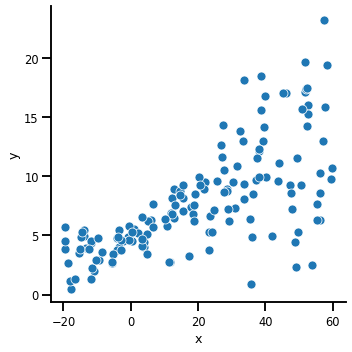

In [28]:
sns.relplot(x="x", y="y", data=df)

Seems linear enough -- let's build a linear regression model to test it out.

In [33]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),  # Note that we're explicitly modeling the output of our Dense layer as a TensorFlow Probability distribution.
])

# Do inference.
model.compile(optimizer=tf.optimizers.RMSprop(0.01), loss='mse')
history = model.fit(x, y, epochs=1000, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()]);




....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

By using our `tfp.layers` object in the definition of the model, we manage to create a TensorFlow Probability **Distribution** as our output of calling the model. Compare this to previously, when we simply got a NumPy Array object out.

In [32]:
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

In [10]:
yhat

<tfp.distributions.Normal 'sequential_distribution_lambda_Normal' batch_shape=[150, 1] event_shape=[] dtype=float32>

TensorFlow Probability distributions have the nice feature that we can do statistical things on them, like draw samples.

In [34]:
ten = yhat.sample(1000)

In [35]:
df = pd.DataFrame(ten.numpy().reshape(1000, 150))

In [41]:
x_tst[::30]

array([[-20.       ],
       [ -3.8926175],
       [ 12.214766 ],
       [ 28.322147 ],
       [ 44.42953  ]], dtype=float32)

In [36]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,1.544733,1.860827,3.134407,2.170182,1.548745,3.106273,2.756859,3.814498,3.283445,3.462998,...,12.000576,12.295212,11.361012,12.945680,10.812623,14.161109,11.446565,12.956407,13.592715,11.196753
1,1.554664,2.786059,2.373746,1.894328,3.532647,2.171350,4.288656,3.738988,2.320176,2.904801,...,13.215436,10.728210,12.141186,15.291488,11.943602,12.754238,13.210694,10.981981,12.211451,14.370539
2,1.621750,2.370113,4.870532,2.987027,1.495230,1.824124,3.866048,3.787565,4.132286,2.678154,...,11.758809,12.070890,11.727518,12.544065,11.148698,12.924579,12.258595,12.218261,14.152033,12.605579
3,0.536005,2.306864,3.568117,0.735339,2.832510,3.819913,2.461787,3.247793,3.612332,2.024112,...,11.681019,12.667989,12.458561,11.317060,12.222528,14.100141,13.012797,11.612029,11.246121,14.986909
4,2.121671,2.485792,1.953312,1.874979,2.830505,5.915194,2.073532,3.716487,3.811028,4.288152,...,12.462126,13.815883,11.389911,12.783714,11.197717,11.693788,12.598664,12.492978,12.589794,14.642599


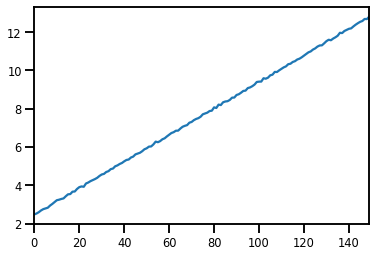

In [42]:
df.mean().plot()

So, the mean of the predicted data increases linearly with the size of the input. This matches our intuition.

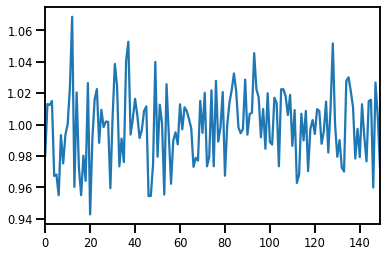

In [43]:
df.std().plot()

However, the standard deviation doesn't seem to change. It looks like it's mostly homoskedastic. Let's check this out with the actual data.

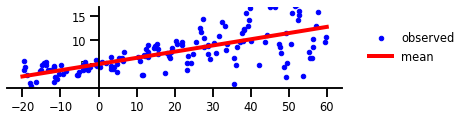

In [44]:
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig1.png', bbox_inches='tight', dpi=300)

This looks like an ok model (and it's about as far as we can go with traditional linear regression for these input data), but it's clear that we actually should have a lot _more_ uncertainty as the magnitudes of our input x's increase. 

Adding a little uncertainty

In [46]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)  # Note that this step is exactly the same as before, except we changed the loss function being called!
history = model.fit(x, y, epochs=1000, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()]);

# Profit.
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [47]:
ten = yhat.sample(1000)
pd.DataFrame(ten.numpy().reshape(1000, 150))

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,2.928053,2.368765,1.861968,3.355159,2.592629,2.655148,1.993174,2.901541,2.925207,3.288276,...,11.364669,16.876772,14.248578,10.314631,14.343067,11.044865,13.495032,14.514527,13.267918,13.298943
1,2.717953,2.268754,2.567499,2.548288,3.108703,3.413827,2.543835,2.915479,2.140433,2.768120,...,14.178868,11.603724,11.045246,8.669735,11.957632,7.761427,13.758648,12.421066,12.001439,18.463144
2,2.149928,3.169148,2.669223,2.579956,3.023014,2.193494,3.018431,1.967959,2.901355,2.712081,...,12.347519,14.714731,11.935478,8.294392,17.362171,12.383027,14.417746,12.622488,12.751778,13.904662
3,3.370398,3.242937,2.264990,2.151198,3.185965,3.080117,2.902607,3.619918,2.773715,3.334933,...,12.232836,14.770294,13.969912,11.796305,14.540228,13.294010,11.922236,10.755639,10.398666,9.664621
4,2.240905,2.569131,2.452543,3.078751,3.127448,3.535044,2.589013,2.603511,1.733986,3.066860,...,11.316258,10.796313,11.813175,16.907585,12.926741,11.041100,10.319795,15.872639,15.568388,16.075218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.573956,2.798611,2.198146,2.497067,2.524860,2.442246,3.492317,2.488231,2.509146,3.122231,...,12.972382,11.649618,11.885075,12.816072,11.666939,11.825907,12.425867,13.095071,15.170846,13.327527
996,2.725618,2.581771,2.819297,2.733663,3.193517,2.332372,2.564599,3.423180,3.475048,3.516228,...,9.471350,12.937387,13.320050,13.930697,12.331967,15.002879,11.113768,10.489434,14.729620,13.628157
997,1.867131,2.486626,2.609945,2.900636,2.542017,2.422646,2.998107,3.530543,2.906350,3.076818,...,9.994440,15.094827,8.194059,13.868344,12.610603,13.399127,16.376791,11.439997,14.616704,14.087389
998,2.382165,2.714376,2.764950,1.916037,2.637582,2.799376,3.176094,3.044058,3.551960,3.589753,...,14.618747,11.328932,12.998150,15.369312,10.878214,12.747065,13.702252,9.684857,7.707679,8.836574


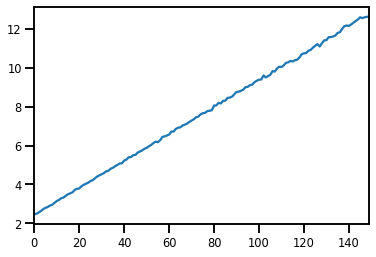

In [48]:
df = pd.DataFrame(ten.numpy().reshape(1000, 150))
df.mean().plot()

The mean looks the same as before -- that's good.

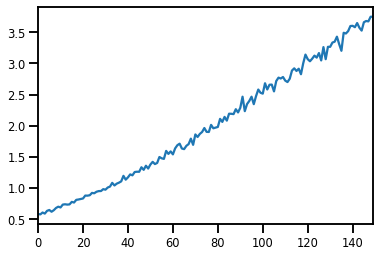

In [131]:
df.std().plot()

And, we've captured the heteroskedasticity present in our model now!

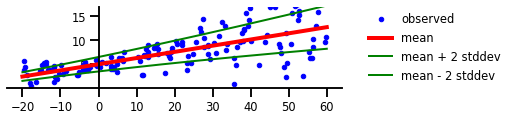

In [49]:
plt.figure(figsize=[6, 1.5])
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

Great! We've appropriately indicated that there's more _variance_ in the model as it gets further away from zero.

## Specifying uncertainty in the model slope

We've outlined how to capture uncertainty in the model outputs, but what about uncertainty in the model's definition itself? In order to do this, we'll need to replace our previous _Dense_ layer with a _Dense Variational_ layer, using TensorFlow Probability Distributions' nice feature of interoperability with Keras.

In [51]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [52]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

In [53]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

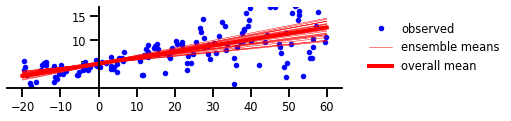

In [54]:
plt.figure(figsize=[6, 1.5])  # inches
plt.clf();
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 25:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig3.png', bbox_inches='tight', dpi=300)

This is great! Now we can show the potential _range_ of slopes that are potentially available to our model, rather than a simple point estimate for one of them.

In [147]:
ten = yhat.sample(1000)
pd.DataFrame(ten.numpy().reshape(1000, 150))

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,1.552424,0.760501,1.247313,2.889966,-0.019315,1.615469,1.419850,1.102464,2.056000,1.805199,...,15.329249,14.656571,13.632469,13.842851,12.931072,15.616471,15.720244,13.195615,15.277653,15.613438
1,2.285291,1.656591,0.767931,2.303886,2.971070,2.616139,4.366810,1.545023,1.820153,1.839453,...,15.415807,14.464284,14.789846,14.755189,14.763699,15.247680,15.235682,17.344900,15.020657,16.875381
2,2.763784,1.615687,1.130968,1.301431,1.125949,3.058823,2.683483,2.455543,1.391794,2.879734,...,12.219523,14.845323,16.151571,14.999207,16.745764,14.552946,15.100413,16.429148,16.023617,15.120370
3,2.537127,1.222663,0.457845,1.649814,0.493726,1.981964,0.587914,2.140439,3.066182,2.239419,...,15.144929,14.234408,14.920633,15.364311,13.992259,16.725327,15.024484,15.407141,14.144545,15.011994
4,2.076679,2.754653,1.810593,2.305200,2.844594,4.239262,1.295198,2.134102,3.025796,3.282442,...,15.417192,15.299866,15.411624,15.762377,13.299819,13.680159,15.194858,13.504980,15.665866,16.105949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.326951,1.771669,1.078336,2.181252,1.685958,2.830403,3.775921,2.034803,4.808228,1.866332,...,14.983624,14.386356,13.312456,14.529682,15.475427,14.980182,16.628668,18.062618,13.879256,14.230822
996,2.054746,1.449341,3.028808,2.825797,2.944778,1.988732,3.033177,1.855427,3.717828,3.859599,...,13.721714,15.243591,14.689014,14.946458,14.956748,16.026114,14.071601,16.064585,16.046677,15.722652
997,1.375680,0.055361,2.123269,1.937333,3.366348,2.511569,2.968378,2.270982,0.848260,1.530303,...,14.423787,14.953510,14.526228,14.202236,15.711918,15.476938,14.927301,14.204308,15.211013,15.414977
998,2.115325,2.284934,2.866725,2.557662,1.617716,2.563022,2.911752,3.019732,4.800770,1.777719,...,14.888395,13.514606,15.972212,13.441167,15.166151,13.597878,14.477619,15.938074,15.794999,15.619616


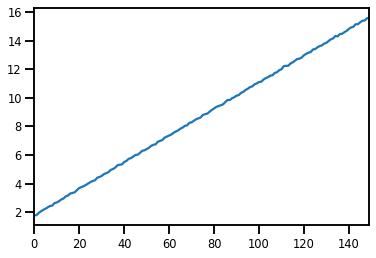

In [148]:
df = pd.DataFrame(ten.numpy().reshape(1000, 150))
df.mean().plot()

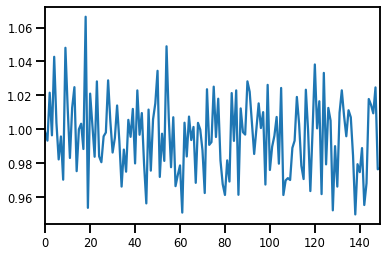

In [149]:
df.std().plot()